# Here, I build out the Langevin integrator capacities of my system. 

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import plotly
import plotly.graph_objects as grapher
import nbformat
# from __future__ import annotations
from typing import Optional, Tuple, List, Literal, Callable
from numpy.typing import NDArray

FloatArray = NDArray[np.floating]


One can choose numerous potential energy functions. These describe how the (relative) positions of particles affect the energy of the system. Because we are running a Langevin integrator which is grounded in Newtonian dynamics, we care about forces and their effects on momenta. However, it is often convenient to keep track of potentials, as they are usually relatively simple functions of the position vector of a system. Depending on the integrator used, many scientific applications allow you to design potentials symbolically, eg `Spring_Potential = ''0.5*k*x^2''`. These integrators then have tables, or symbolic differentiators, to differentiate the potential into a force. This project won't attempt to do that; instead, I'll build functions that get $U$ and $\nabla U$ directly depending on the type of potential specified. 

Perhaps the simplest potential is a harmonic potential, $U(x) = \frac{1}{2}kx^2.$ Observe that $-D_xU = F_x = -kx $, where the subscript $x$ denotes the x component or differentiating in the $x$ direction. For our harmonic potentials, we can imagine a spring between each pair of particles. We thus sum the pairwise potentials for each bead: $$U_{\mathrm{sys}} = \sum_{i < j}\frac{1}{2}k||q_i-q_j||^2 = \frac{1}{2}k \sum_{i<j}||q_i-q_j||^2.$$ To take the gradient, we differentiate wrt each component of $q$: $$(\nabla U)_i = D_{q_i}U = \frac{1}{2}k\sum_{j \neq i} D_{q_i}||q_i-q_j||^2 = k\sum_{j \neq i} (q_i-q_j).$$ We lose most of the terms because they are constant wrt $q_i$, and we lose the magnitude/absolute value at the end because because we can think of this as differentiating $\mathbf{r} \cdot \mathbf{r}$. 

We often want to simulate a sub-region of a system so that we don't have to consider boundary conditions. This is a good idea, but we run into a conundrum: our goal is to avoid boundaries, and we've just brought our boundaries in closer. The solution is clear: periodic boundary conditions. We use the isometry/ergodicity of our system, and assume we're in a relatively representative sub-box. Then we consider particles that leave off to the right to correspond to particles appearing from the left, and vice-versa. This is the classic dynamic representatino of movement on the 2-torus. The only problem is the following: if particles A and B are adjacent to each other at the boundary and B crosses, suddenly the force between them goes to 0. The solution to this problem is the minimum-image convention (https://en.wikipedia.org/wiki/Periodic_boundary_conditions).

In [345]:
# implement our harmonic potentials

def get_harmonic_U(k,L):
    def U(q):
        difs = q[:, None, :] - q[None, :, :]      # Here, we create a matrix of differences q_i - q_j
        difs -= L * np.round(difs / L)             
# The line above solves the Minimum Image Convention Problem. 
# If two particles have a distance that is close to L, we subtract that distance. 
# This basically means that particles choose the closer of two interaction distances: 
# the obvious distance within the torus, or the distance across the toroidal boundary. 
        sumSquares = np.sum(difs**2,axis=2) # sum the x,y, and z components to get an N x N matrix

        return(0.5*k*np.sum(np.triu(sumSquares,k=1))) # we only care about the unique pairs
    return(U) 

def get_harmonic_Nabla(k,L):
    def Nabla(q):
        difs = q[:, None, :] - q[None, :, :]      # See function above for explanatino
        difs -= L * np.round(difs / L)  
        return(k* np.sum(difs,axis = 1)) # sum over j, noting that the dif for j=i is 0
    return(Nabla) 


We want to apply B A O A B. In the README.md file attached, we describe these terms in more detail. The important thing to note here is that A depends on p and is applied to q, while B depends on q and is applied to p. The beauty of BAOAB is that it allows us to freeze q wrt p and p wrt q for the A and B steps by examining variable-specific flows. Hence, integrating these operations over dt is equivalent to integrating a constant. In particular, we have $$\int \frac{dq}{dt}dt = \int \frac{p}{M}dt \implies \Delta q = \Delta t\frac{p}{M} $$ with a similar result for $B$. However, the $O$ operation is applied to $p$ and depends on $p$. We have $$\int \frac{dp}{dt} = \int -\gamma p + \xi(t) \sqrt{2\gamma k_B Tm} \ dt.$$ Letting $\sigma = \sqrt{2\gamma k_B Tm}$ and $\xi(t)dt = W_t$, a vector of $N$ independent Wiener processes. Then we use a technique common in the soft sciences (physics, eg.) and multiply by $e^{\gamma t}$ to get $$\begin{aligned}  d(e^{\gamma t}p) = \gamma e^{\gamma t}p dt + e^{\gamma t}dp = \gamma e^{\gamma t}pdt + e^{\gamma t}(-\gamma p dt + \sigma d W_t)  = \sigma e^{\gamma t}dW_t \end{aligned}.$$ We can then integrate as physicists, getting $$   \int d(e^{\gamma t}p) = \sigma \int e^{\gamma t} dW_t  \implies e^{\gamma (t + dt)}p(t+dt) - e^{\gamma t}p(t) = \sigma \int _t ^{t + dt} e^{\gamma t} dW_s$$ where the RHS is a bizarre integral over our stochastic function. Then simple algebra gives $$  p(t + dt) = e^{-\gamma dt}p(t) + \sigma \int_t^{t + dt} e^{\gamma (s-t-dt)}dW_s.$$

How do we evaluate that integral? This requires some stochastic calculus beyond the scope of this writeup. See https://en.wikipedia.org/wiki/It%C3%B4_calculus. In particular, we apply the Ito isometry $$\mathbb{E}[(\int_0^{t}g(s))^2]= \mathbb{E}[\int_0^{t}(g(s))^2]$$and, observing that we're integrating a Brownian motion process and so get 0 mean, we have the variance for free (that is, we subtract off the square of the expectation value of our integral), arriving at $$\mathrm{Var}= \int_t^{t+dt}(\sigma e^{\gamma(s-t-dt)})^2ds,$$ which is easily evaluated; we let $a = e^{-\gamma dt}$, and arrive at $$p(t+dt) = ap(t)+ \sqrt{mk_B T(1-a^2)}\xi,$$ where again $\xi \sim \mathscr{N}(0,1)$ and the coefficient before it is the standard deviation we arrived at in the integral above (recall that $\mathrm{Var}(ax) = a^2\mathrm{Var}(x)).$

Hence, to apply our 'O' step, we need only scale $p$ by a factor of $a$ and add a normally distributed kick with the appropriate scaling. Unfortunately, `1-((e**x)**2)` is quite numerically unstable; for very small (on the order of dt) x, `e**x` can get uncomfortably close to 1; squaring can become a mess, and then you risk catestrophic cancellation subtracting two numbers close to 1. Luckily numpy has plenty of built in tools for this. 

In [346]:
def apply_A(p,q,dt,M):
    # the A operator doesn't touch p, but it adjusts q (position) via Newton
    q += p/M * dt # careful! numpy will broadcast M.shape = (N,1) but not (N,)... need to keep an eye out
    return(p,q)

def apply_B(p,q,dt,getNablaU):
    # the A operator applies the newtonian force kick 
    F = -getNablaU(q)
    p += F*dt
    return(p,q)

def apply_O(p,q,dt,gamma,M,kB,T,rng):
    # the O operator adds thermal randomness to our system
    # it only adjusts p

    # a = np.exp(-gamma*dt)
    # stdev = np.sqrt(M*kB*T*(1-a**2)) # NOTE: probably want to make this more stable later on
    ## when dt is small, a is close to 1, so 1-a**2 is close to 0; this can make the above unstable
    ## Hence, use the following: 

    a = np.exp(-gamma*dt)
    one_minus_a2 = np.expm1(-2*gamma*dt) * (-1)   # equals 1 - a**2 with better accuracy
    one_minus_a2 = np.clip(one_minus_a2, 0.0, 1.0) # clip to avoid more floating point errors
    stdev = np.sqrt(M*kB*T*(one_minus_a2))
    xi = rng.normal(size = p.shape)
    p = a*p + stdev * xi

    return(p,q)

## Main Function to Run the Simulation

In [347]:
def run(p0:Optional[FloatArray] = None,q0:Optional[FloatArray] = None,N: int = 10,
        M:Optional[FloatArray]=None,
        dt:float = 1.e-3,num_steps:int = 10*3,T:float = 1.0,gamma:float = 1.0,kB:float = 1.0,systemLength:float = 10**4,
        rng = np.random.default_rng(42),
        potential_type = "harmonic",kSpring:float = 1.0,
        timing = False, printing_steps = False):
    
    other_data = {}


    if potential_type == "harmonic":
        getNabla = get_harmonic_Nabla(kSpring,systemLength)
        getU = get_harmonic_U(kSpring,systemLength)

    p=p0
    q=q0


    q_table,p_table,U_table = [q.copy()],[p.copy()],[getU(q)]

    def save_data(p,q):
        q_table.append(q.copy())
        p_table.append(p.copy())
        U_table.append(getU(q))


    def BAOAB(p,q):
        # perform BAOAB
        p,q = apply_B(p,q,dt/2,getNabla)

        p,q = apply_A(p,q,dt/2,M)
        # apply periodic boundary conditions

        q = np.mod(q,systemLength)
        p,q = apply_O(p,q,dt,gamma,M,kB,T,rng)
        p,q = apply_A(p,q,dt/2,M)

        # apply periodic boundary conditions
        q = np.mod(q,systemLength)

        p,q = apply_B(p,q,dt/2,getNabla)
        return(p,q)


    if timing: 
        start = time.perf_counter()

    #### MAIN LOOP ####
    for step in range(num_steps):

        if printing_steps and step>0 and step % int(num_steps//10) == 0:
                print(f"At step {step} out of {num_steps}")

        p,q = BAOAB(p,q)
        save_data(p,q)
        
    
    if timing: 
        end = time.perf_counter()
        other_data['time'] = end-start
    other_data['systemLength'] = systemLength
    other_data['T'] = T
    other_data['kB'] = kB
    other_data['gamma'] = gamma
    other_data['dt'] = dt

    
    return (np.array(p_table),np.array(q_table),np.array(U_table),other_data)


# Experiments

### Basic First Experiment

In [348]:
# First experiment: reduced units

rng = np.random.default_rng(42)


N= 2 # number of particles

p = np.empty((N,3),dtype=float) # momentum vector
q= p.copy() # position vector
M = np.ones((N,1),dtype=float) 
dt = 1.e-3
num_steps = 10**3 
T = 1.0
gamma = 1.0
kB = 10 

# starting positins in a small Gaussian, then center at (0,0,0)
q = 10 * rng.normal(size=(N,3))
q -= q.mean(axis=0, keepdims=True)

# starting momenta are boltzmann distributed with stdev = sqrt(mkBT) per component
p_std = np.sqrt(M * kB * T)         
p0 = 10*p_std * rng.normal(size=(N,3))
# here, we 'center' the momenta so they're not biased in a given direction
p -= p.mean(axis=0, keepdims=True)
p0,q0 = p,q

potential_type = "harmonic"
kSpring=1.0

pTable,qTable,UTable,other_Data = run(p0,q0,num_steps=num_steps,
                           N=N,M=M,dt=dt,gamma=gamma,kB=kB,T=T,
                           potential_type="harmonic",
                           timing = True,printing_steps=True)

print(f"other data = {other_Data}")

print(qTable.shape)

At step 100 out of 1000
At step 200 out of 1000
At step 300 out of 1000
At step 400 out of 1000
At step 500 out of 1000
At step 600 out of 1000
At step 700 out of 1000
At step 800 out of 1000
At step 900 out of 1000
other data = {'time': 0.042986041167750955, 'systemLength': 10000, 'T': 1.0, 'kB': 10, 'gamma': 1.0, 'dt': 0.001}
(1001, 2, 3)


#### Some Simple Timing Experiments: NOT RUNNING
- Note that I reuse most of the parameters from the first experiment

In [349]:
timing_experiments = False
if timing_experiments:
    time_table_in_N = []
    Ns = []
    for exp in np.arange(1,6,0.1):
        N_exp = 10**exp
        print(f"N = {N_exp}")
        Ns.append(exp)
        _,_,_,o = run(p0,q0,num_steps=num_steps,
                            N=N_exp,M=M,dt=dt,gamma=gamma,kB=kB,T=T,
                            potential_type="harmonic",
                            timing = True,printing_steps=False)
        time_table_in_N.append(o['time'])

    plt.plot(Ns,time_table_in_N)
    plt.title('Timing vs N')
    plt.xlabel('N')
    plt.ylabel('Time (s)')
    plt.show()

# Visualization

In [350]:
import numpy as np
import plotly.graph_objects as go

def plot_md(qTable, L=10.0, trail=15, stride=1, title="Langevin MD (Plotly)", 
            point_size=3, box=True, outfile=None):
    """
    qTable: (T, N, 3) positions; assumed already wrapped to [0,L) if you do PBC in the loop
    trail:  number of previous frames to show as a fading tail
    stride: subsample frames for speed (1 = every frame)
    box:    draw wireframe box
    outfile: if set, writes a self-contained HTML
    """
    q = qTable[::stride]
    T, N, _ = q.shape

    # Build traces for the current frame + trail
    def frame_data(t):
        traces = []
        # current positions
        traces.append(go.Scatter3d(
            x=q[t,:,0], y=q[t,:,1], z=q[t,:,2],
            mode="markers",
            marker=dict(size=point_size),
            name="t",
            showlegend=False
        ))
        # trail (fading)
        kmax = min(trail, t)
        for k in range(1, kmax+1):
            alpha = 1.0 - k/(kmax+1)
            traces.append(go.Scatter3d(
                x=q[t-k,:,0], y=q[t-k,:,1], z=q[t-k,:,2],
                mode="markers",
                marker=dict(size=max(1, point_size-1), opacity=alpha),
                hoverinfo="skip",
                showlegend=False
            ))
        return traces

    # First frame
    data0 = frame_data(0)

    # Frames
    frames = [go.Frame(data=frame_data(t), name=str(t)) for t in range(T)]

    # Scene/layout
    axes = dict(range=[0, L], showgrid=False, zeroline=False, title='')
    layout = go.Layout(
        title=title,
        scene=dict(xaxis=axes, yaxis=axes, zaxis=axes, aspectmode="cube"),
        width=800, height=700,
        updatemenus=[
            {
                "type": "buttons",
                "showactive": False,
                "y": 0,
                "x": 0,
                "xanchor": "left",
                "buttons": [
                    {"label": "Play", "method": "animate",
                     "args": [None, {"frame": {"duration": 30, "redraw": True},
                                     "fromcurrent": True, "transition": {"duration": 0}}]},
                    {"label": "Pause", "method": "animate",
                     "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                       "mode": "immediate",
                                       "transition": {"duration": 0}}]}
                ],
            }
        ],
        sliders=[{
            "steps": [{"args": [[str(k)], {"frame": {"duration": 0, "redraw": True},
                                           "mode": "immediate"}],
                       "label": str(k), "method": "animate"} for k in range(T)],
            "currentvalue": {"prefix": "frame: "}
        }]
    )

    fig = go.Figure(data=data0, frames=frames, layout=layout)

    # Optional: wireframe box
    if box:
        corners = np.array([[0,0,0],[L,0,0],[L,L,0],[0,L,0],[0,0,0],
                            [0,0,L],[L,0,L],[L,L,L],[0,L,L],[0,0,L]])
        edges = [(0,1),(1,2),(2,3),(3,0),(5,6),(6,7),(7,8),(8,5),(0,5),(1,6),(2,7),(3,8)]
        for a,b in edges:
            fig.add_trace(go.Scatter3d(
                x=[corners[a,0], corners[b,0]],
                y=[corners[a,1], corners[b,1]],
                z=[corners[a,2], corners[b,2]],
                mode="lines",
                line=dict(width=2),
                hoverinfo="skip",
                showlegend=False
            ))

    if outfile:
        fig.write_html(outfile, include_plotlyjs="cdn")
    return fig

# Example:


In [351]:
# fig = plot_md(qTable, L=10**4, trail=20, stride=2, outfile="md.html")
# fig.show(renderer="browser")

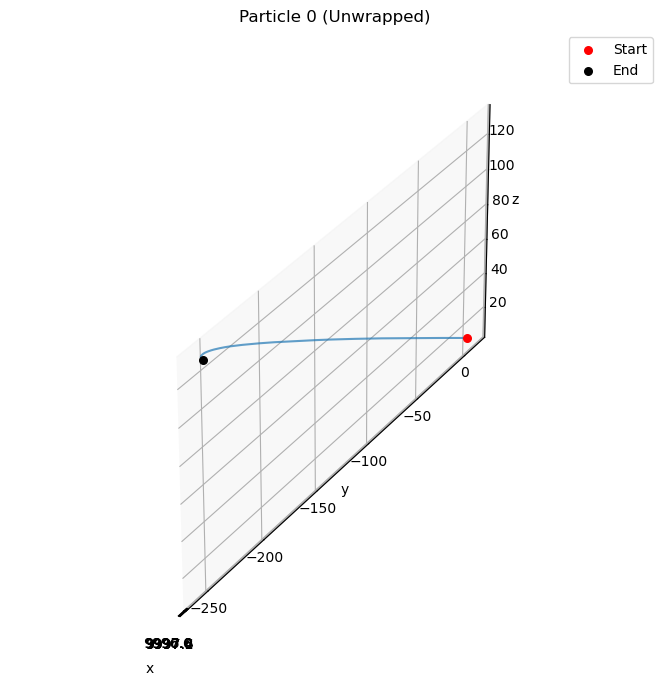

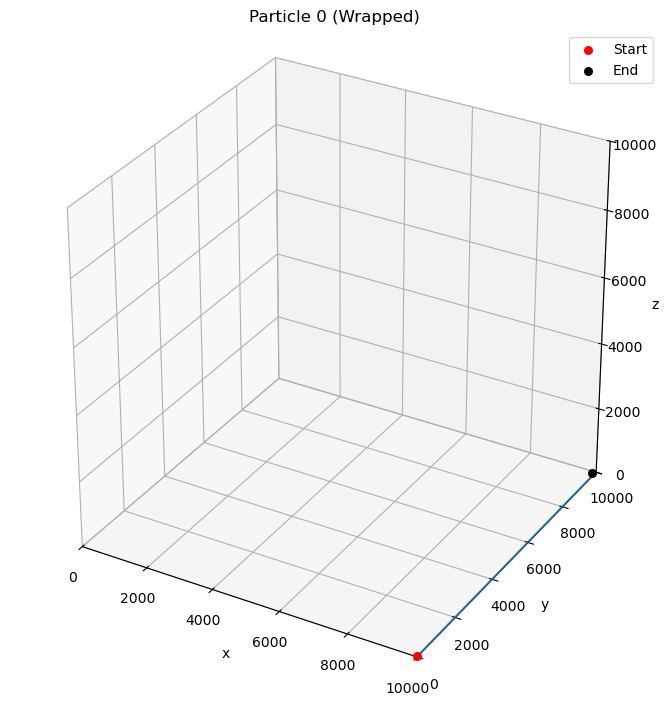

In [352]:
import numpy as np
import matplotlib.pyplot as plt

# This helper function is correct and essential
def _unwrap(traj, L):
    """Reconstructs a continuous trajectory from wrapped coordinates."""
    d = np.diff(traj, axis=0)
    d -= L * np.round(d / L) # Minimum image convention on the *difference*
    return np.vstack([traj[0], traj[0] + np.cumsum(d, axis=0)])

def plot_traj3d(qTable, L, idx=0, unwrap=True, stride=1, tails=None):
    """
    Plots the 3D trajectory of a single particle.
    
    Args:
        qTable (np.array): Full position table (timesteps, N, 3)
        L (float): Box length (systemLength)
        idx (int): Particle index to plot
        unwrap (bool): If True, reconstructs the continuous path across boundaries.
        stride (int): Plot every 'stride'-th point.
        tails (int): Only plot the last 'tails' number of points.
    """
    q = qTable[::stride, idx]
    if tails is not None: 
        q = q[-tails:]
    
    plot_title = f"Particle {idx}"

    if unwrap:
        q = _unwrap(q, L) # Reconstruct the continuous path
        plot_title += " (Unwrapped)"
    else:
        plot_title += " (Wrapped)"

    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection="3d")
    
    # Plot the trajectory line
    ax.plot(q[:,0], q[:,1], q[:,2], lw=1.5, alpha=0.7)
    
    # Plot start (red) and end (black) points
    ax.scatter(q[0,0], q[0,1], q[0,2], s=30, c="r", label="Start", depthshade=False)
    ax.scatter(q[-1,0], q[-1,1], q[-1,2], s=30, c="k", label="End", depthshade=False)
    
    ax.set(xlabel="x", ylabel="y", zlabel="z", title=plot_title)
    
    if not unwrap:
        # If we are *not* unwrapping, set the box limits
        ax.set(xlim=(0,L), ylim=(0,L), zlim=(0,L))

    try: 
        # This makes the axes scales equal, giving a true-to-life path
        ax.set_aspect('equal')
    except NotImplementedError:
        # Fallback for older matplotlib versions
        pass 
        
    ax.legend()
    plt.tight_layout()
    return fig, ax

# %%
# --- HOW TO RUN IT ---

# 1. To see the continuous path (what you probably want):
fig, ax = plot_traj3d(qTable, L=10**4.0, idx=0, unwrap=True, stride=2, tails=500)
plt.show()

# 2. To see the "spaghetti" plot (what you were getting):
fig, ax = plot_traj3d(qTable, L=10**4.0, idx=0, unwrap=False, stride=2, tails=500)
plt.show()

In [353]:
np.set_printoptions(threshold=np.inf)
# print(qTable[:,0])
print(pTable.shape)
print(pTable[:,0])

(1001, 2, 3)
[[ 0.00000000e+00 -5.60000000e+02  2.80000000e+02]
 [ 4.94272829e-02 -5.59595829e+02  2.79805421e+02]
 [ 7.38035456e-02 -5.59088642e+02  2.79502025e+02]
 [ 8.94185284e-02 -5.58376807e+02  2.79266831e+02]
 [ 2.19853723e-01 -5.57830961e+02  2.78939101e+02]
 [ 1.65444211e-01 -5.57327263e+02  2.78712514e+02]
 [ 4.74356359e-01 -5.56830626e+02  2.78337948e+02]
 [ 4.64129217e-01 -5.56394683e+02  2.77919065e+02]
 [ 3.75947919e-01 -5.55806490e+02  2.77633080e+02]
 [ 4.77889292e-01 -5.55241038e+02  2.77371199e+02]
 [ 4.17275873e-01 -5.54774899e+02  2.77029267e+02]
 [ 1.85335436e-01 -5.54265147e+02  2.76749020e+02]
 [ 1.42208987e-01 -5.53772815e+02  2.76566770e+02]
 [ 1.84530103e-02 -5.53144240e+02  2.76283007e+02]
 [ 1.13213659e-01 -5.52629189e+02  2.76043408e+02]
 [-4.95806703e-02 -5.52000988e+02  2.75672582e+02]
 [ 5.08731910e-02 -5.51455067e+02  2.75308093e+02]
 [-1.29790375e-01 -5.51035630e+02  2.75059760e+02]
 [-1.73666947e-01 -5.50370302e+02  2.74622649e+02]
 [-4.83633090e-02 